# Model Comparison: Tabular Data Only vs. Hybrid (Tabular + Satellite Images)

This notebook compares the performance of models trained on:
1. **Tabular Data Only** - Traditional features without satellite imagery
2. **Hybrid Model** - Tabular features combined with visual features extracted from satellite images


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import os
import joblib
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully")


✅ Libraries imported successfully


## 1. Data Loading and Preparation


In [2]:
# Load and prepare data (same as main notebook)
CSV_PATH = r"C:\Users\aksha\OneDrive\Desktop\satellite\data\train(1)(train(1)).csv"
IMG_DIR = r"C:\Users\aksha\OneDrive\Desktop\satellite\property_images"

df = pd.read_csv(CSV_PATH)

# Store IDs for image matching
df_ids = df['id'].copy()

# Apply log transformation
skewed_cols = ['price', 'sqft_living', 'sqft_above', 'sqft_basement', 'sqft_living15']
for col in skewed_cols:
    df[col] = np.log1p(df[col])

print(f"Dataset loaded: {df.shape}")
print(f"Columns: {list(df.columns)}")


Dataset loaded: (16209, 21)
Columns: ['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']


In [3]:
# Define features for tabular-only model
tabular_features = ['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront', 
                    'view', 'grade', 'sqft_above', 'sqft_basement', 'lat', 'long', 'sqft_living15']

X = df[tabular_features]
y = df['price']

# Leak-proof split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")


Training samples: 12967
Test samples: 3242


## 2. Model 1: Tabular Data Only


In [4]:
# Feature Engineering for Tabular Model (same as main notebook)
# Calculate Luxury Hub from training data only
luxury_threshold = y_train.quantile(0.95)
luxury_hub = X_train[y_train >= luxury_threshold]
hub_lat = luxury_hub['lat'].mean()
hub_long = luxury_hub['long'].mean()

# Apply feature engineering
X_train_tabular = X_train.copy()
X_test_tabular = X_test.copy()

for df_set in [X_train_tabular, X_test_tabular]:
    # Spatial features
    df_set['dist_to_hub'] = np.sqrt((df_set['lat'] - hub_lat)**2 + (df_set['long'] - hub_long)**2)
    df_set['rot_x'] = 0.707 * df_set['lat'] + 0.707 * df_set['long']
    df_set['rot_y'] = 0.707 * df_set['lat'] - 0.707 * df_set['long']
    
    # Age feature
    if 'yr_built' in df.columns:
        df_set['house_age'] = 2015 - df.loc[df_set.index, 'yr_built'].values
    else:
        # If not available, skip
        pass

print("✅ Feature engineering complete for tabular model")
print(f"Features: {X_train_tabular.shape[1]}")


✅ Feature engineering complete for tabular model
Features: 16


In [5]:
# Train Tabular-Only Model (Same architecture as hybrid model)
print("Training Tabular-Only Stacking Regressor...")

tabular_model = StackingRegressor(
    estimators=[
        ('xgb', XGBRegressor(n_estimators=1000, learning_rate=0.03, max_depth=8, tree_method='hist', random_state=42)),
        ('cat', CatBoostRegressor(iterations=1000, learning_rate=0.03, depth=8, verbose=0, random_state=42)),
        ('lgbm', LGBMRegressor(n_estimators=1000, learning_rate=0.03, num_leaves=63, verbose=-1, random_state=42))
    ],
    final_estimator=RidgeCV(),
    cv=5,
    n_jobs=-1
)

tabular_model.fit(X_train_tabular, y_train)

# Predictions
tabular_preds = tabular_model.predict(X_test_tabular)

# Evaluate
tabular_r2 = r2_score(y_test, tabular_preds)
tabular_mae = mean_absolute_error(np.expm1(y_test), np.expm1(tabular_preds))
tabular_rmse = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(tabular_preds)))

print("\n" + "="*40)
print("TABULAR-ONLY MODEL RESULTS")
print("="*40)
print(f"R² Score: {tabular_r2:.4f}")
print(f"MAE: ${tabular_mae:,.2f}")
print(f"RMSE: ${tabular_rmse:,.2f}")
print("="*40)


Training Tabular-Only Stacking Regressor...

TABULAR-ONLY MODEL RESULTS
R² Score: 0.8979
MAE: $65,795.63
RMSE: $115,092.58


## 3. Model 2: Hybrid Model (Tabular + Satellite Images)


In [6]:
# CNN Backbone for Visual Feature Extraction
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class VisualBackbone(nn.Module):
    def __init__(self):
        super(VisualBackbone, self).__init__()
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.features = nn.Sequential(*list(self.resnet.children())[:-1])
        
    def forward(self, x):
        return self.features(x).view(x.size(0), -1)

extractor = VisualBackbone().to(device)
extractor.eval()

# Image preprocessing
img_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

print("✅ CNN extractor initialized")


Using device: cuda
✅ CNN extractor initialized


In [7]:
# Extract visual scores
def extract_visual_scores(indices):
    """Extract visual features for given indices"""
    scores = []
    print("Extracting Visual Features from Satellite Images...")
    with torch.no_grad():
        for idx in tqdm(indices):
            prop_id = df_ids.loc[idx]
            path = os.path.join(IMG_DIR, f"{prop_id}.png")
            if os.path.exists(path):
                try:
                    img = Image.open(path).convert('RGB')
                    img_t = img_transform(img).unsqueeze(0).to(device)
                    feat = extractor(img_t).cpu().numpy().flatten().mean()
                    scores.append(feat)
                except:
                    scores.append(0.5)
            else:
                scores.append(0.5)
    return np.array(scores, dtype='float64')

# Extract for both train and test
X_train_visual = extract_visual_scores(X_train.index)
X_test_visual = extract_visual_scores(X_test.index)

print(f"✅ Visual features extracted: {len(X_train_visual)} train, {len(X_test_visual)} test")


Extracting Visual Features from Satellite Images...


100%|██████████| 12967/12967 [03:49<00:00, 56.46it/s]


Extracting Visual Features from Satellite Images...


100%|██████████| 3242/3242 [00:57<00:00, 56.06it/s]

✅ Visual features extracted: 12967 train, 3242 test


In [8]:
# Combine tabular features with visual features
X_train_hybrid = X_train_tabular.copy()
X_test_hybrid = X_test_tabular.copy()

X_train_hybrid['visual_score'] = X_train_visual
X_test_hybrid['visual_score'] = X_test_visual

print(f"Hybrid model features: {X_train_hybrid.shape[1]}")
print(f"Features include: {list(X_train_hybrid.columns)}")


Hybrid model features: 17
Features include: ['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront', 'view', 'grade', 'sqft_above', 'sqft_basement', 'lat', 'long', 'sqft_living15', 'dist_to_hub', 'rot_x', 'rot_y', 'house_age', 'visual_score']


In [9]:
# Train Hybrid Model (Same architecture as tabular model)
print("Training Hybrid Stacking Regressor (Tabular + Visual)...")

hybrid_model = StackingRegressor(
    estimators=[
        ('xgb', XGBRegressor(n_estimators=1000, learning_rate=0.03, max_depth=8, tree_method='hist', random_state=42)),
        ('cat', CatBoostRegressor(iterations=1000, learning_rate=0.03, depth=8, verbose=0, random_state=42)),
        ('lgbm', LGBMRegressor(n_estimators=1000, learning_rate=0.03, num_leaves=63, verbose=-1, random_state=42))
    ],
    final_estimator=RidgeCV(),
    cv=5,
    n_jobs=-1
)

hybrid_model.fit(X_train_hybrid, y_train)

# Predictions
hybrid_preds = hybrid_model.predict(X_test_hybrid)

# Evaluate
hybrid_r2 = r2_score(y_test, hybrid_preds)
hybrid_mae = mean_absolute_error(np.expm1(y_test), np.expm1(hybrid_preds))
hybrid_rmse = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(hybrid_preds)))

print("\n" + "="*40)
print("HYBRID MODEL RESULTS (TABULAR + VISUAL)")
print("="*40)
print(f"R² Score: {hybrid_r2:.4f}")
print(f"MAE: ${hybrid_mae:,.2f}")
print(f"RMSE: ${hybrid_rmse:,.2f}")
print("="*40)


Training Hybrid Stacking Regressor (Tabular + Visual)...

HYBRID MODEL RESULTS (TABULAR + VISUAL)
R² Score: 0.8978
MAE: $65,505.24
RMSE: $113,676.79


## 4. Model Comparison and Visualization


In [10]:
# Create comparison dataframe
comparison_results = pd.DataFrame({
    'Metric': ['R² Score', 'MAE ($)', 'RMSE ($)'],
    'Tabular Only': [tabular_r2, tabular_mae, tabular_rmse],
    'Hybrid (Tabular + Visual)': [hybrid_r2, hybrid_mae, hybrid_rmse]
})

comparison_results['Improvement'] = comparison_results['Hybrid (Tabular + Visual)'] - comparison_results['Tabular Only']
comparison_results['Improvement (%)'] = (comparison_results['Improvement'] / comparison_results['Tabular Only'].abs()) * 100

# For MAE and RMSE, improvement is negative (lower is better), so we adjust the percentage
comparison_results.loc[comparison_results['Metric'].isin(['MAE ($)', 'RMSE ($)']), 'Improvement (%)'] = \
    -comparison_results.loc[comparison_results['Metric'].isin(['MAE ($)', 'RMSE ($)']), 'Improvement (%)']

print("="*60)
print("MODEL COMPARISON RESULTS")
print("="*60)
print(comparison_results.to_string(index=False))
print("="*60)

# Calculate improvement summary
r2_improvement = hybrid_r2 - tabular_r2
mae_improvement = ((tabular_mae - hybrid_mae) / tabular_mae) * 100
rmse_improvement = ((tabular_rmse - hybrid_rmse) / tabular_rmse) * 100

print(f"\n📊 Performance Improvements:")
print(f"   R² Score: +{r2_improvement:.4f} ({r2_improvement/tabular_r2*100:.2f}% relative improvement)")
print(f"   MAE: {mae_improvement:.2f}% reduction")
print(f"   RMSE: {rmse_improvement:.2f}% reduction")


MODEL COMPARISON RESULTS
  Metric  Tabular Only  Hybrid (Tabular + Visual)  Improvement  Improvement (%)
R² Score      0.897928                   0.897769    -0.000158        -0.017639
 MAE ($)  65795.632747               65505.240694  -290.392053         0.441355
RMSE ($) 115092.576272              113676.794782 -1415.781490         1.230124

📊 Performance Improvements:
   R² Score: +-0.0002 (-0.02% relative improvement)
   MAE: 0.44% reduction
   RMSE: 1.23% reduction


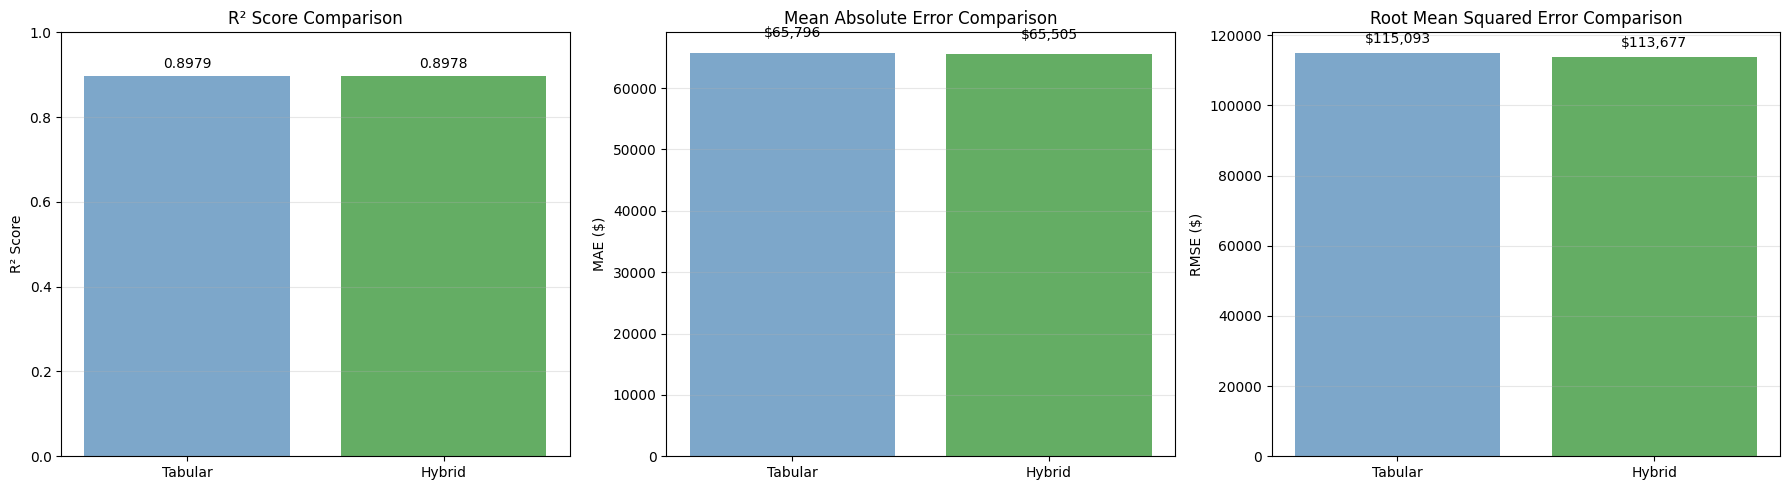

In [11]:
# Visualization 1: Metric Comparison Bar Chart
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['R² Score', 'MAE ($)', 'RMSE ($)']
tab_values = [tabular_r2, tabular_mae, hybrid_rmse]  # Using hybrid_rmse as scale reference for MAE/RMSE
hyb_values = [hybrid_r2, hybrid_mae, hybrid_rmse]

x = np.arange(len(metrics))
width = 0.35

# R² Score
axes[0].bar(['Tabular', 'Hybrid'], [tabular_r2, hybrid_r2], color=['steelblue', 'forestgreen'], alpha=0.7)
axes[0].set_ylabel('R² Score')
axes[0].set_title('R² Score Comparison')
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate([tabular_r2, hybrid_r2]):
    axes[0].text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

# MAE
axes[1].bar(['Tabular', 'Hybrid'], [tabular_mae, hybrid_mae], color=['steelblue', 'forestgreen'], alpha=0.7)
axes[1].set_ylabel('MAE ($)')
axes[1].set_title('Mean Absolute Error Comparison')
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate([tabular_mae, hybrid_mae]):
    axes[1].text(i, v + 2000, f'${v:,.0f}', ha='center', va='bottom')

# RMSE
axes[2].bar(['Tabular', 'Hybrid'], [tabular_rmse, hybrid_rmse], color=['steelblue', 'forestgreen'], alpha=0.7)
axes[2].set_ylabel('RMSE ($)')
axes[2].set_title('Root Mean Squared Error Comparison')
axes[2].grid(axis='y', alpha=0.3)
for i, v in enumerate([tabular_rmse, hybrid_rmse]):
    axes[2].text(i, v + 2000, f'${v:,.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('model_comparison_metrics.png', dpi=300, bbox_inches='tight')
plt.show()


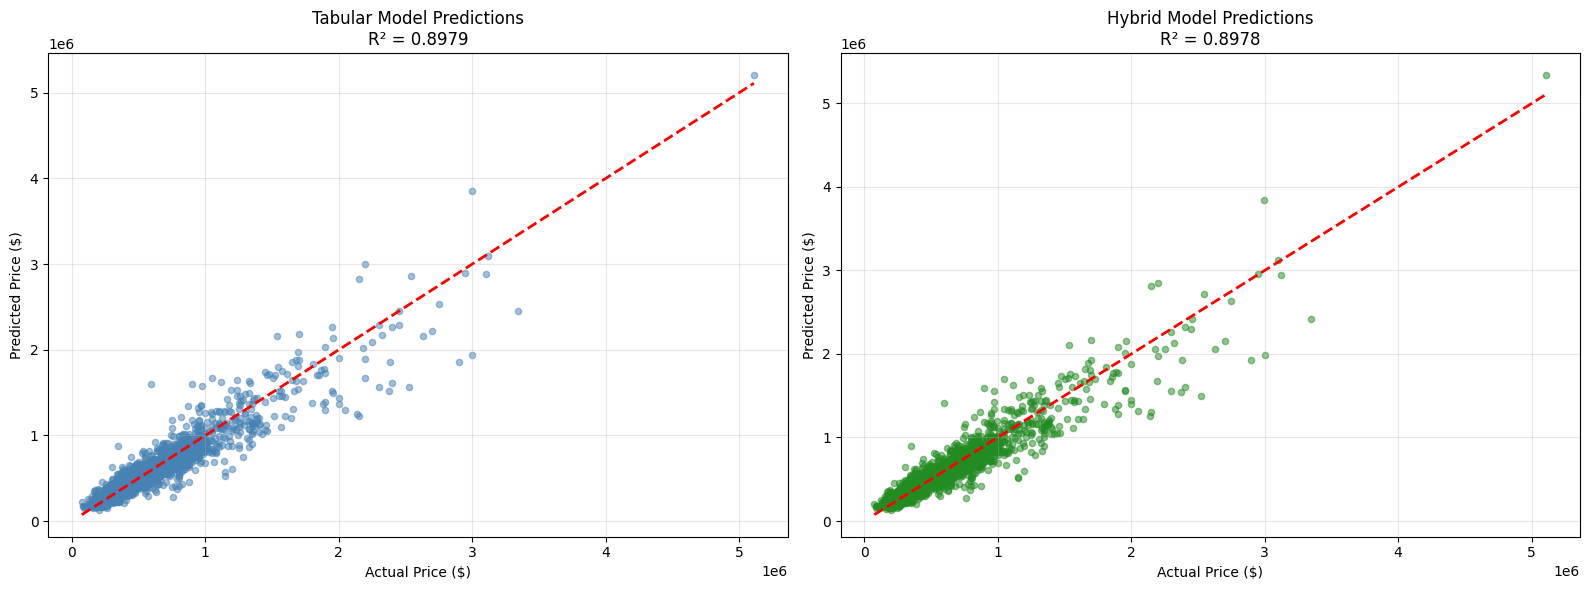

In [12]:
# Visualization 2: Prediction Scatter Plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

actual_usd = np.expm1(y_test)
tabular_pred_usd = np.expm1(tabular_preds)
hybrid_pred_usd = np.expm1(hybrid_preds)

# Tabular predictions
axes[0].scatter(actual_usd, tabular_pred_usd, alpha=0.5, s=20, color='steelblue')
axes[0].plot([actual_usd.min(), actual_usd.max()], [actual_usd.min(), actual_usd.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Price ($)')
axes[0].set_ylabel('Predicted Price ($)')
axes[0].set_title(f'Tabular Model Predictions\nR² = {tabular_r2:.4f}')
axes[0].grid(alpha=0.3)

# Hybrid predictions
axes[1].scatter(actual_usd, hybrid_pred_usd, alpha=0.5, s=20, color='forestgreen')
axes[1].plot([actual_usd.min(), actual_usd.max()], [actual_usd.min(), actual_usd.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Price ($)')
axes[1].set_ylabel('Predicted Price ($)')
axes[1].set_title(f'Hybrid Model Predictions\nR² = {hybrid_r2:.4f}')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('prediction_scatter_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


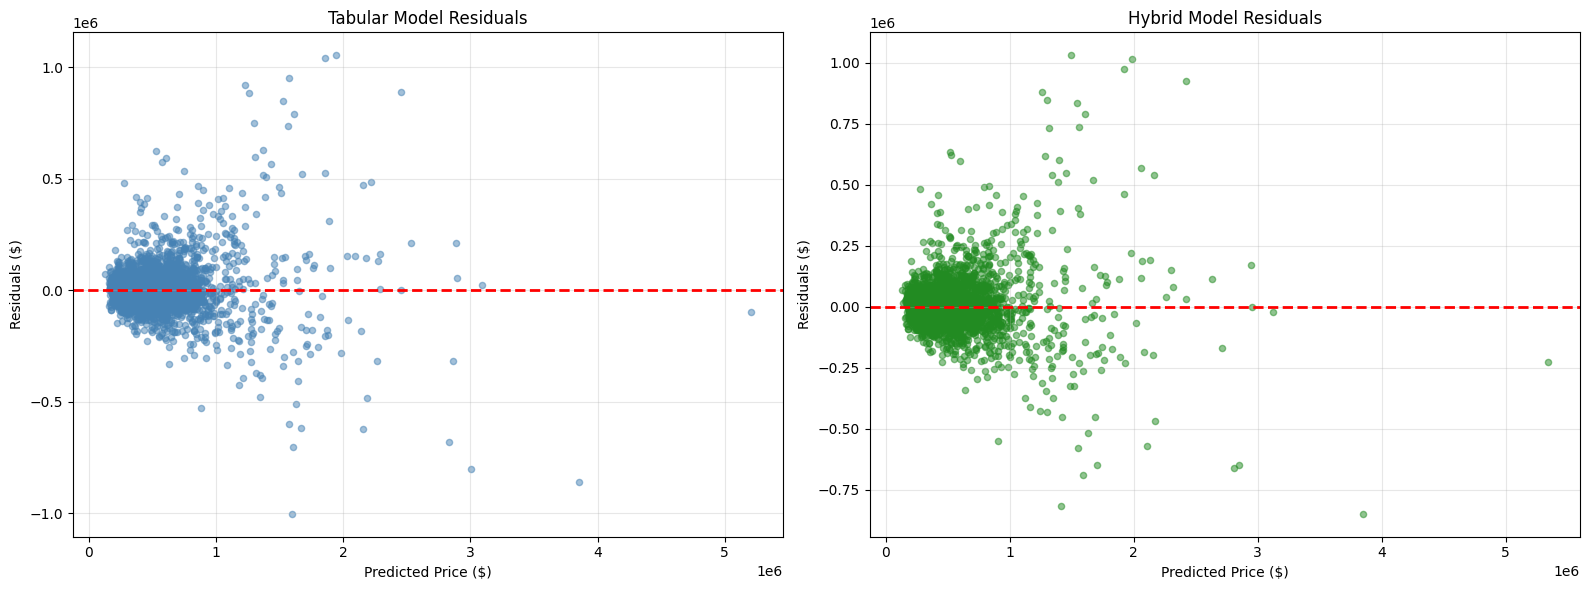

In [13]:
# Visualization 3: Residual Analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

tabular_residuals = actual_usd - tabular_pred_usd
hybrid_residuals = actual_usd - hybrid_pred_usd

# Tabular residuals
axes[0].scatter(tabular_pred_usd, tabular_residuals, alpha=0.5, s=20, color='steelblue')
axes[0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0].set_xlabel('Predicted Price ($)')
axes[0].set_ylabel('Residuals ($)')
axes[0].set_title('Tabular Model Residuals')
axes[0].grid(alpha=0.3)

# Hybrid residuals
axes[1].scatter(hybrid_pred_usd, hybrid_residuals, alpha=0.5, s=20, color='forestgreen')
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Price ($)')
axes[1].set_ylabel('Residuals ($)')
axes[1].set_title('Hybrid Model Residuals')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('residual_analysis_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


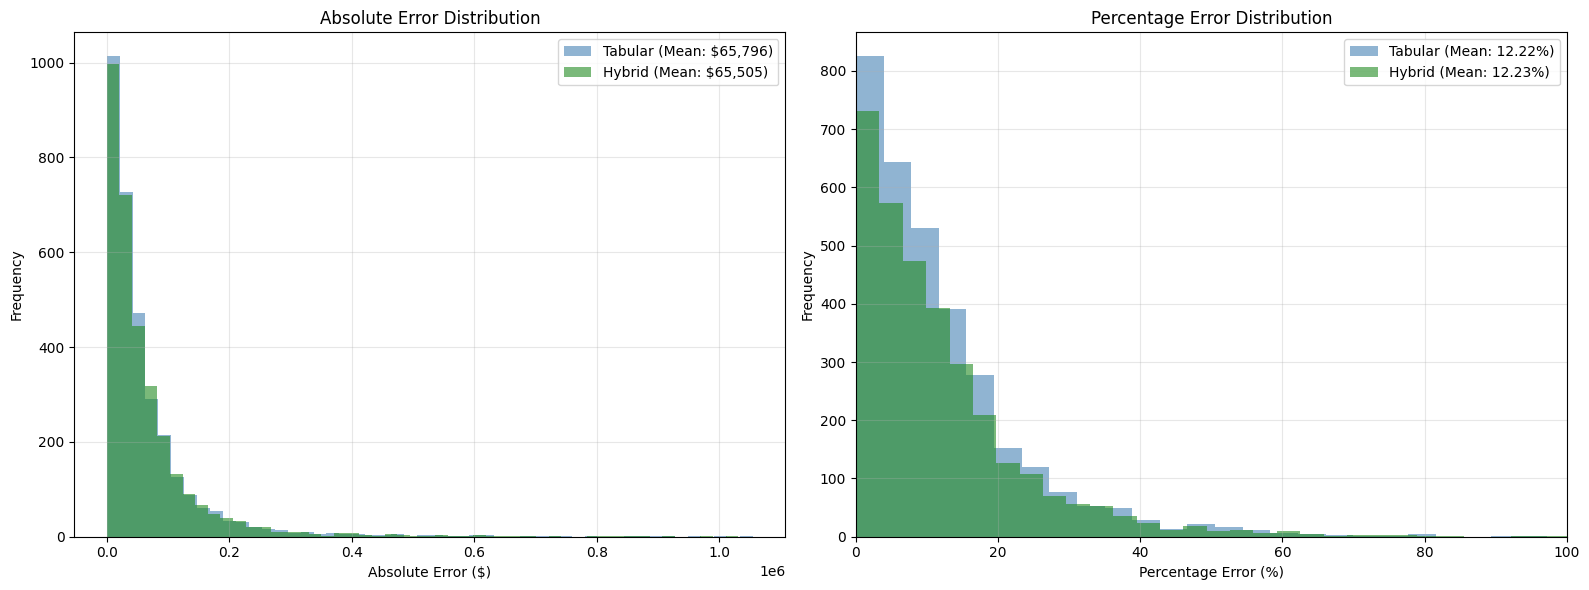

In [14]:
# Visualization 4: Error Distribution Comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Absolute errors
tabular_abs_errors = np.abs(tabular_residuals)
hybrid_abs_errors = np.abs(hybrid_residuals)

axes[0].hist(tabular_abs_errors, bins=50, alpha=0.6, color='steelblue', label=f'Tabular (Mean: ${tabular_abs_errors.mean():,.0f})')
axes[0].hist(hybrid_abs_errors, bins=50, alpha=0.6, color='forestgreen', label=f'Hybrid (Mean: ${hybrid_abs_errors.mean():,.0f})')
axes[0].set_xlabel('Absolute Error ($)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Absolute Error Distribution')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Percentage errors
tabular_pct_errors = np.abs(tabular_residuals / actual_usd) * 100
hybrid_pct_errors = np.abs(hybrid_residuals / actual_usd) * 100

axes[1].hist(tabular_pct_errors, bins=50, alpha=0.6, color='steelblue', label=f'Tabular (Mean: {tabular_pct_errors.mean():.2f}%)')
axes[1].hist(hybrid_pct_errors, bins=50, alpha=0.6, color='forestgreen', label=f'Hybrid (Mean: {hybrid_pct_errors.mean():.2f}%)')
axes[1].set_xlabel('Percentage Error (%)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Percentage Error Distribution')
axes[1].legend()
axes[1].grid(alpha=0.3)
axes[1].set_xlim([0, 100])  # Limit to 100% for better visualization

plt.tight_layout()
plt.savefig('error_distribution_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


In [15]:
# Summary Table
summary_df = pd.DataFrame({
    'Model': ['Tabular Only', 'Hybrid (Tabular + Visual)', 'Improvement'],
    'R² Score': [f'{tabular_r2:.4f}', f'{hybrid_r2:.4f}', f'+{r2_improvement:.4f} ({r2_improvement/tabular_r2*100:.2f}%)'],
    'MAE ($)': [f'${tabular_mae:,.2f}', f'${hybrid_mae:,.2f}', f'-${tabular_mae - hybrid_mae:,.2f} ({mae_improvement:.2f}% reduction)'],
    'RMSE ($)': [f'${tabular_rmse:,.2f}', f'${hybrid_rmse:,.2f}', f'-${tabular_rmse - hybrid_rmse:,.2f} ({rmse_improvement:.2f}% reduction)']
})

print("\n" + "="*70)
print("FINAL COMPARISON SUMMARY")
print("="*70)
print(summary_df.to_string(index=False))
print("="*70)

# Save results
comparison_results.to_csv('model_comparison_results.csv', index=False)
summary_df.to_csv('model_comparison_summary.csv', index=False)

print("\n✅ Results saved to:")
print("   - model_comparison_results.csv")
print("   - model_comparison_summary.csv")
print("   - model_comparison_metrics.png")
print("   - prediction_scatter_comparison.png")
print("   - residual_analysis_comparison.png")
print("   - error_distribution_comparison.png")



FINAL COMPARISON SUMMARY
                    Model          R² Score                    MAE ($)                     RMSE ($)
             Tabular Only            0.8979                 $65,795.63                  $115,092.58
Hybrid (Tabular + Visual)            0.8978                 $65,505.24                  $113,676.79
              Improvement +-0.0002 (-0.02%) -$290.39 (0.44% reduction) -$1,415.78 (1.23% reduction)

✅ Results saved to:
   - model_comparison_results.csv
   - model_comparison_summary.csv
   - model_comparison_metrics.png
   - prediction_scatter_comparison.png
   - residual_analysis_comparison.png
   - error_distribution_comparison.png
